In [28]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [29]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-06-22 14:33:32.196620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 14:33:32.196856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 14:33:32.197016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 14:33:32.197233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 14:33:32.197397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13083224856026308567
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6107365376
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13489300841082813817
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [30]:
# import sys
# log_path = 'log.txt'
# sys.stdout = open(log_path, "w")

import h5py
h5 = h5py.File('./data/All_cases_100x100_per500_zoom_06222022.hdf5', mode='r')
# h5 = h5py.File('./data/All_cases_100x100_per500_zoom.hdf5', mode='r')
dataset = h5.get('phi')

data_sz = dataset.shape[0]
indexes = np.arange(data_sz)
np.random.shuffle(indexes)
train_index = np.sort(indexes[: int(0.75 * data_sz)])
val_index = np.sort(indexes[int(0.75 * data_sz) :])
print(train_index)
print(val_index)
print(dataset.shape)

[ 1  2  3  4  6  8  9 10 11 12 13 14 15 16 17 19 21 22 23 24 26 27 28 29
 30 32 34 35 37 38 39 40 42 43 44 45 46 47 52 53 54 56 57 58 60 61 62 63
 66 67 68 69 70 71 72 73 75 77 79 80 81 83 84 85 86 87 88 89 90]
[ 0  5  7 18 20 25 31 33 36 41 48 49 50 51 55 59 64 65 74 76 78 82 91]
(92, 70, 100, 100, 2)


In [31]:
# this part is a bit slow
train_dataset = dataset[train_index,...]
val_dataset = dataset[val_index,...]

dataset.shape

(92, 70, 100, 100, 2)

In [32]:
def create_shifted_frames_3to1(data):
    x1 = np.expand_dims(data[:, 1 : data.shape[1] - 3, :, :, 0]+data[:, 1 : data.shape[1] - 3, :, :, 1],4)
    x2 = np.expand_dims(data[:, 2 : data.shape[1] - 2, :, :, 0]+data[:, 2 : data.shape[1] - 2, :, :, 1],4)
    x3 = np.expand_dims(data[:, 3 : data.shape[1] - 1, :, :, 0]+data[:, 3 : data.shape[1] - 1, :, :, 1],4)
    x = np.concatenate((x1,x2,x3), axis=4)
    y = data[:, 4 : data.shape[1], :, :, 0]
    y = np.expand_dims(y,4)
    return x,y

x_train, y_train = create_shifted_frames_3to1(train_dataset)
x_val, y_val = create_shifted_frames_3to1(val_dataset)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (69, 66, 100, 100, 3), (69, 66, 100, 100, 1)
Validation Dataset Shapes: (23, 66, 100, 100, 3), (23, 66, 100, 100, 1)


Displaying frames for example 47.


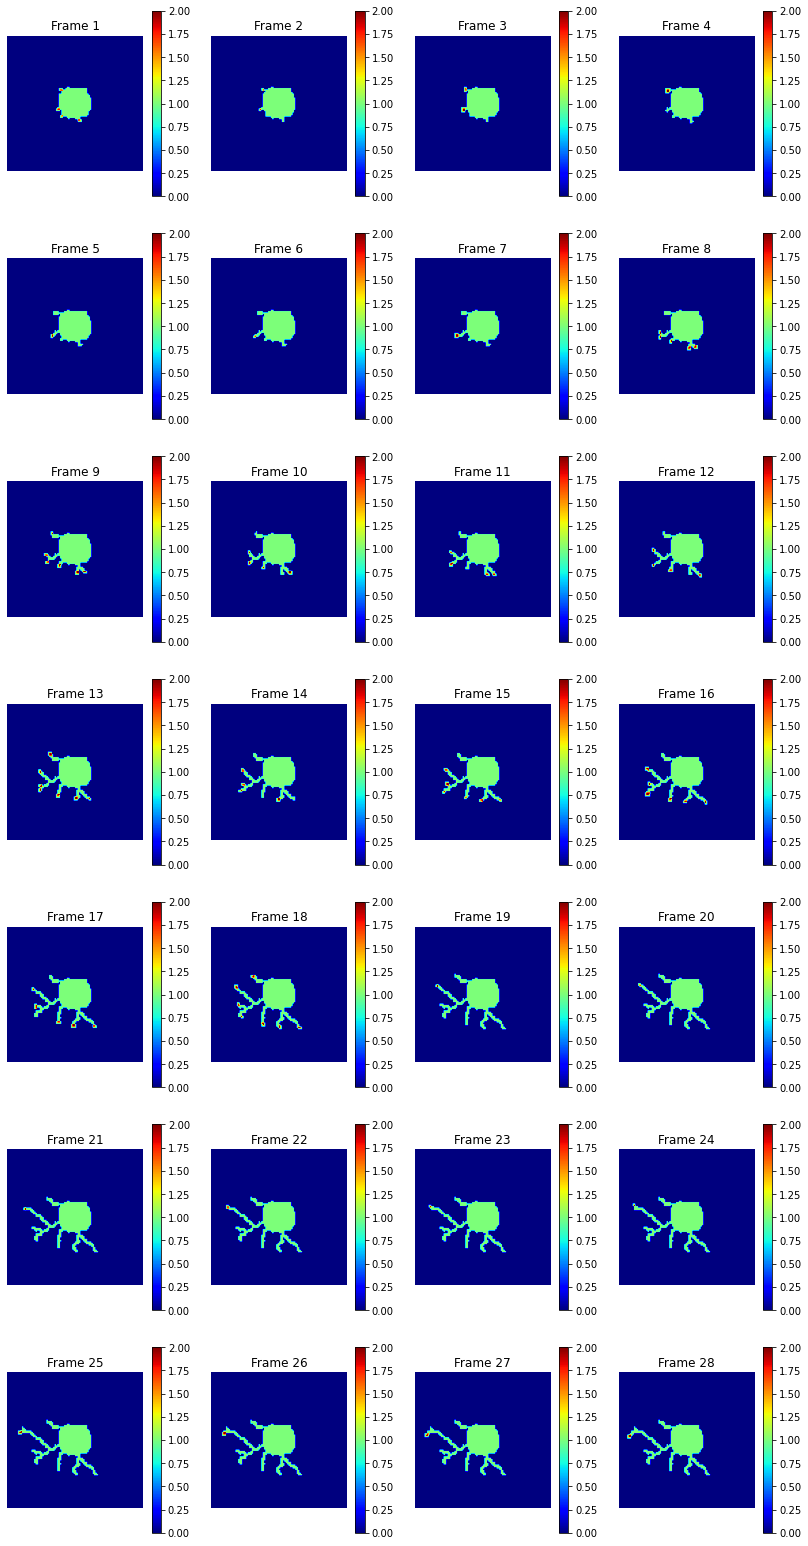

In [33]:
fig, axes = plt.subplots(7, 4, figsize=(14, 28))

data_choice = np.random.choice(range(len(x_train)), size=1)[0]
fig_ind = 1
for idx, ax in enumerate(axes.flat):
    plt.subplot(7,4,fig_ind)
    fig_ind += 1
    plt.imshow(np.squeeze(x_train[data_choice][idx][:,:,0]),cmap='jet')
    plt.title(f"Frame {idx + 1}")
    plt.axis("off")
    plt.colorbar()
    
print(f"Displaying frames for example {data_choice}.")
plt.show()

Displaying frames for example 47.


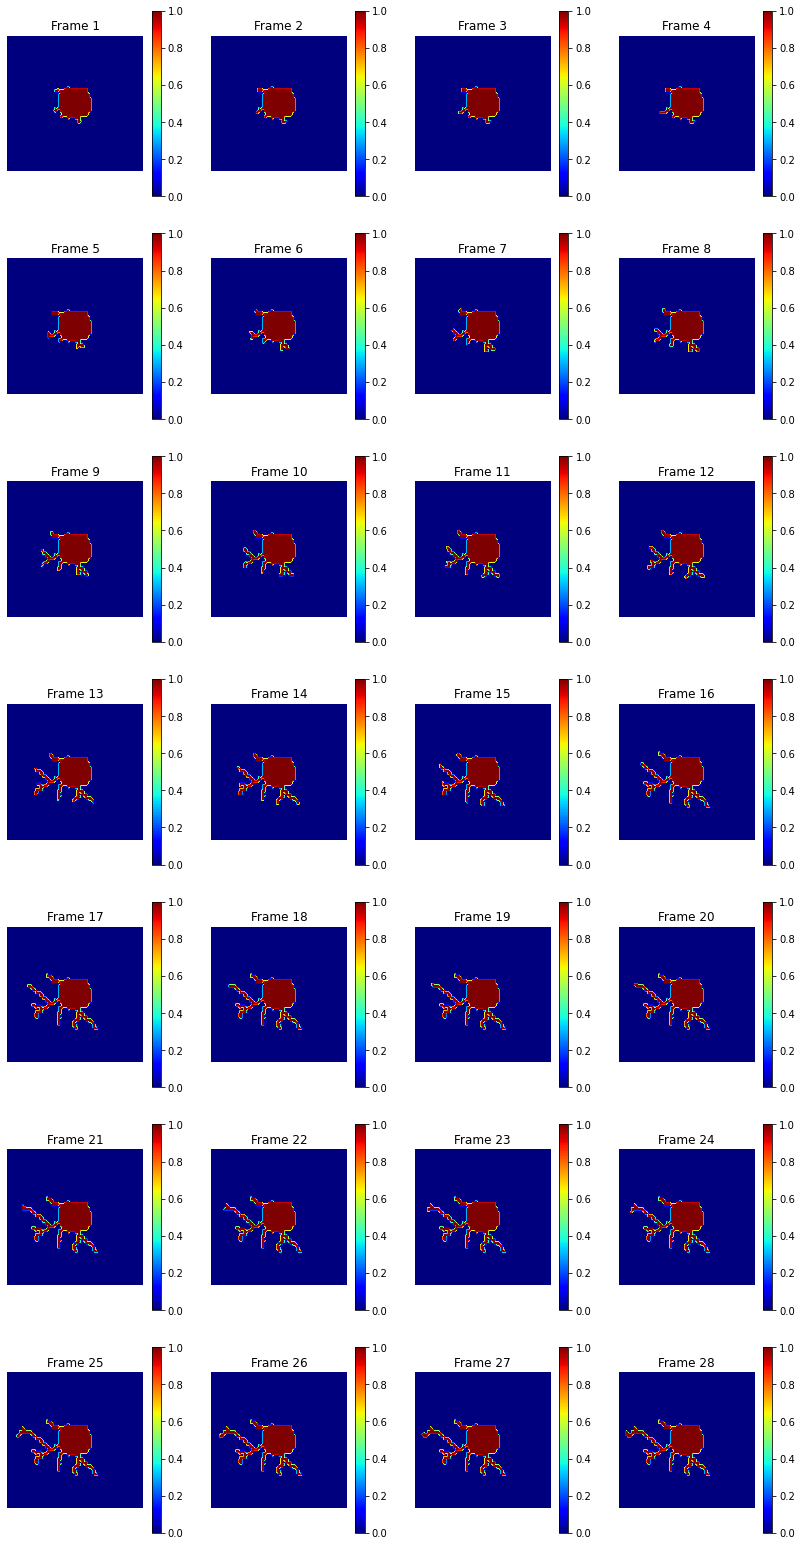

In [34]:
fig, axes = plt.subplots(7, 4, figsize=(14, 28))

fig_ind = 1
for idx, ax in enumerate(axes.flat):
    plt.subplot(7,4,fig_ind)
    fig_ind += 1
    plt.imshow(np.squeeze(y_train[data_choice][idx][:,:,0]),cmap='jet')
    plt.title(f"Frame {idx + 1}")
    plt.axis("off")
    plt.colorbar()
    
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [35]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))

drop_rate = 0.1
x0 = layers.TimeDistributed(layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(inp)
x0 = layers.Dropout(drop_rate)(x0)
x1 = layers.TimeDistributed(layers.Conv2D(
    filters=128,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x0)
x1 = layers.Dropout(drop_rate)(x1)
x2 = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
    recurrent_dropout=drop_rate,
)(x1)
x3 = layers.Concatenate(axis=4)([x1,x2])
x4 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x3)
x4 = layers.Dropout(drop_rate)(x4)
x5 = layers.Concatenate(axis=4)([x0,x4])
x6 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="sigmoid",
))(x5)
x6 = layers.Dropout(drop_rate)(x6)

In [36]:
from keras import backend as K
def mreloss(yTrue, yPred):
    mre = K.sqrt(K.mean(K.square(yPred - yTrue))/(K.max(yPred)-K.min(yPred)))
    return mre

In [37]:
model = keras.models.Model(inp, x6)
model.compile(
    # loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    loss=mreloss,
    optimizer=keras.optimizers.Adam(learning_rate=1e-5))
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 100,   0           []                               
                                100, 3)]                                                          
                                                                                                  
 time_distributed_4 (TimeDistri  (None, None, 48, 48  4864       ['input_2[0][0]']                
 buted)                         , 64)                                                             
                                                                                                  
 dropout_4 (Dropout)            (None, None, 48, 48  0           ['time_distributed_4[0][0]']     
                                , 64)                                                       

In [ ]:
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 2:  # or save after some epoch, each k-th epoch etc.
            self.model.save("model_{}.hd5".format(epoch))

In [38]:
test = False

if test == True:
    model = keras.models.load_model('./saved_model/model_conv_lstm_mre')
else: 
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)

    epochs = 1000
    batch_size = 2
    saver = CustomSaver()

    with tf.device('/device:GPU:0'):
        model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            callbacks=[saver]
            # callbacks=[early_stopping, reduce_lr],
        )
    model.save('./saved_model/model_conv_lstm_mre') 

Epoch 1/500
35/35 [==============================] - 15s 383ms/step - loss: 0.6577 - val_loss: 1.2359
Epoch 2/500
35/35 [==============================] - 13s 376ms/step - loss: 0.5715 - val_loss: 1.0258
Epoch 3/500
35/35 [==============================] - 13s 373ms/step - loss: 0.6024 - val_loss: 0.9475
Epoch 4/500
35/35 [==============================] - 13s 370ms/step - loss: 0.5805 - val_loss: 0.8695
Epoch 5/500
35/35 [==============================] - 13s 372ms/step - loss: 0.5625 - val_loss: 0.8119
Epoch 6/500
35/35 [==============================] - 13s 378ms/step - loss: 0.5486 - val_loss: 0.7669
Epoch 7/500
35/35 [==============================] - 13s 374ms/step - loss: 0.5379 - val_loss: 0.7313
Epoch 8/500
35/35 [==============================] - 13s 378ms/step - loss: 0.5301 - val_loss: 0.7025
Epoch 9/500
35/35 [==============================] - 13s 374ms/step - loss: 0.5242 - val_loss: 0.6788
Epoch 10/500
35/35 [==============================] - 13s 376ms/step - loss: 0.519

INFO:tensorflow:Assets written to: ./saved_model/model_conv_lstm_mre/assets


INFO:tensorflow:Assets written to: ./saved_model/model_conv_lstm_mre/assets


In [39]:
def create_shifted_frames_3to1(data):
    x1 = np.expand_dims(data[:, 1 : data.shape[1] - 3, :, :, 0]+data[:, 1 : data.shape[1] - 3, :, :, 1],4)
    x2 = np.expand_dims(data[:, 2 : data.shape[1] - 2, :, :, 0]+data[:, 2 : data.shape[1] - 2, :, :, 1],4)
    x3 = np.expand_dims(data[:, 3 : data.shape[1] - 1, :, :, 0]+data[:, 3 : data.shape[1] - 1, :, :, 1],4)
    x = np.concatenate((x1,x2,x3), axis=4)
    y = data[:, 4 : data.shape[1], :, :, 0]
    y = np.expand_dims(y,4)
    tips = data[:, 4 : data.shape[1], :, :, 1]
    tips = np.expand_dims(tips,4)
    return x,y,tips

x_val, y_val, tips_val = create_shifted_frames_3to1(val_dataset)

In [40]:
def push(input, cutoff):
    max_input = np.amax(input)
    input[input>cutoff*max_input] = 1
    input[input<=cutoff*max_input] = 0
    return input

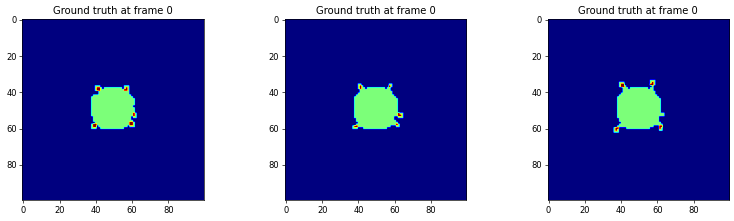

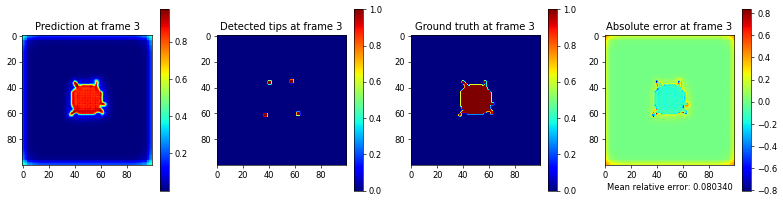

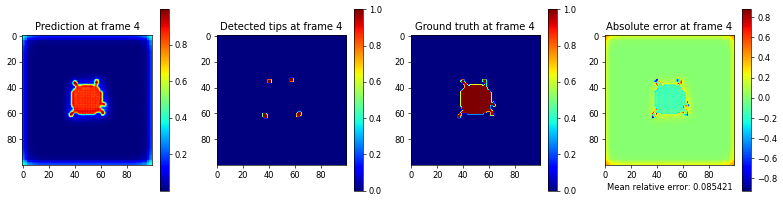

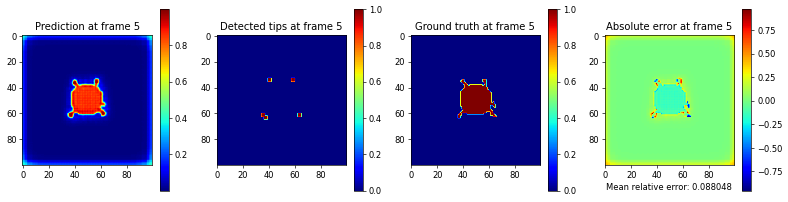

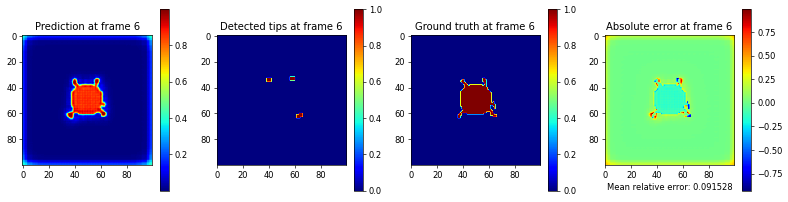

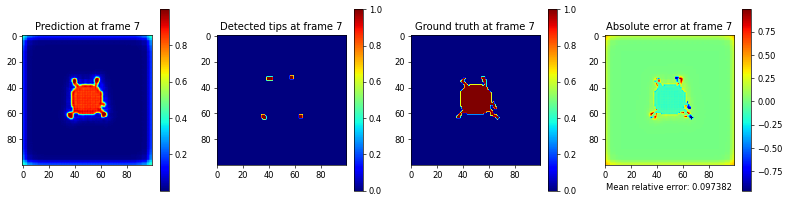

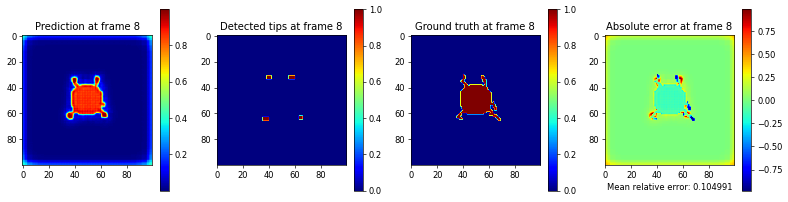

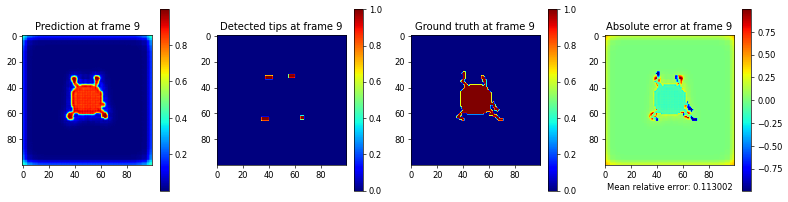

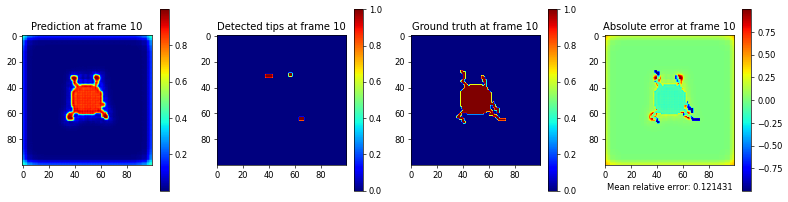

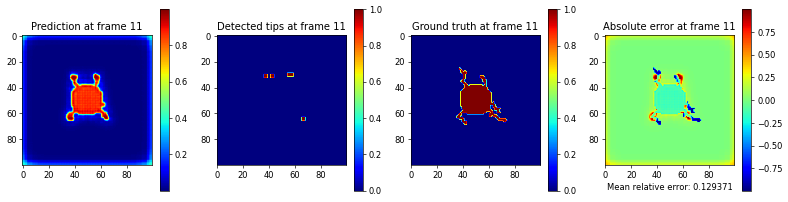

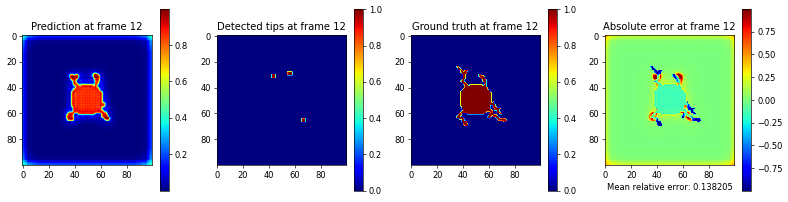

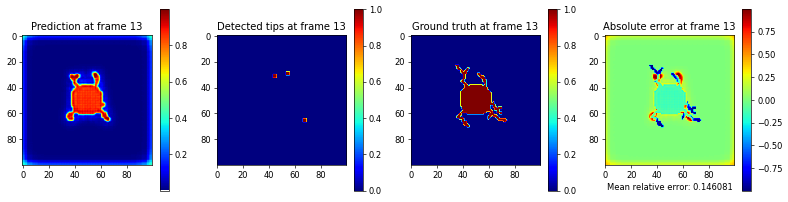

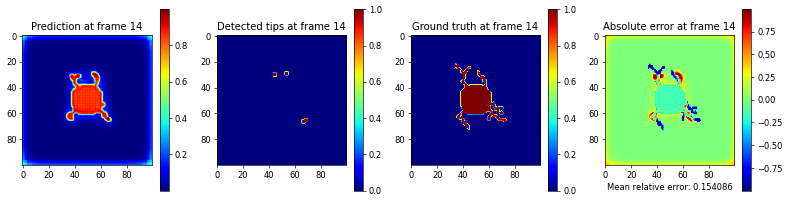

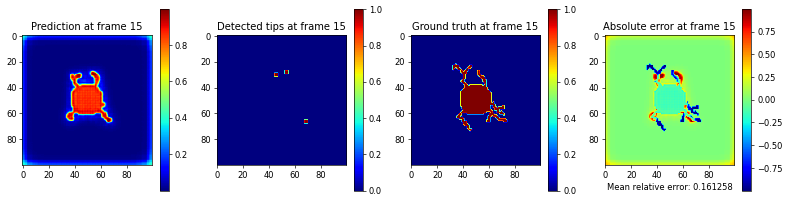

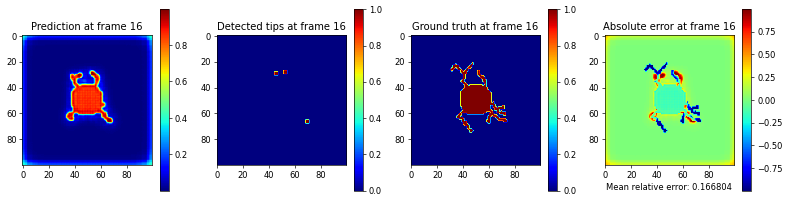

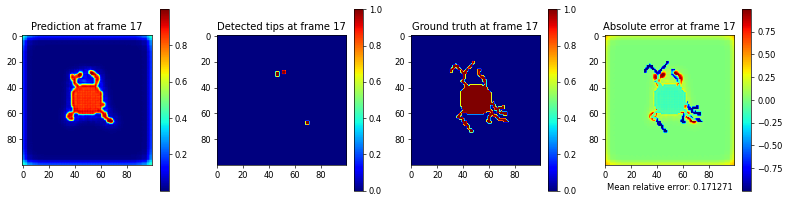

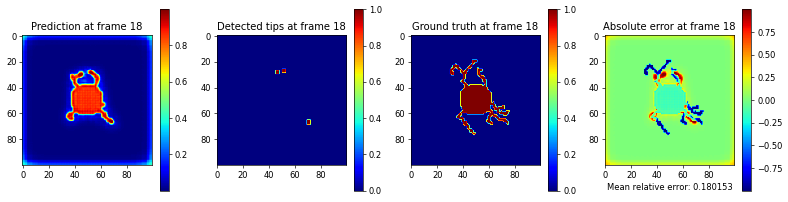

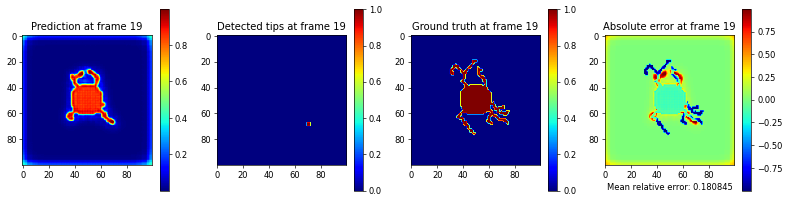

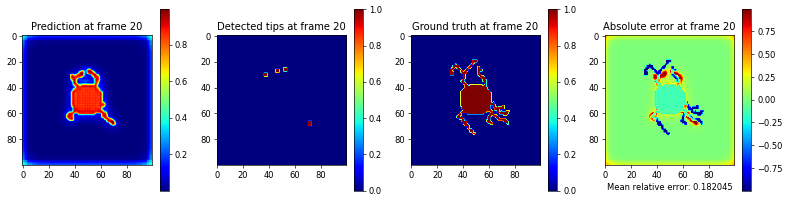

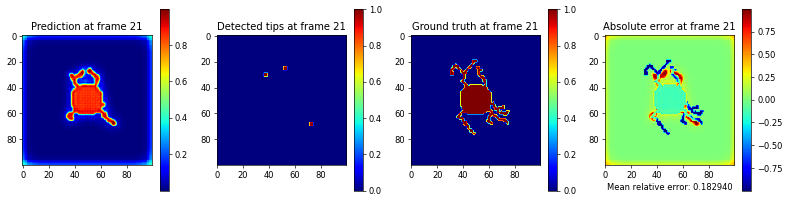

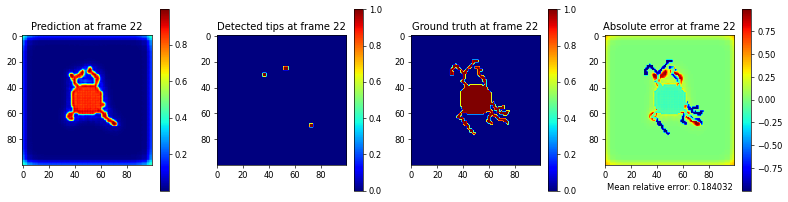

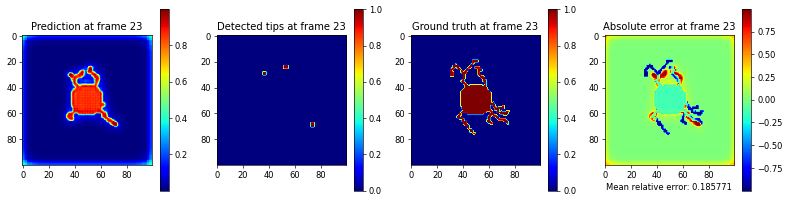

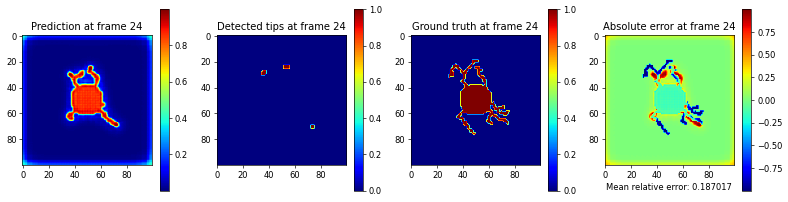

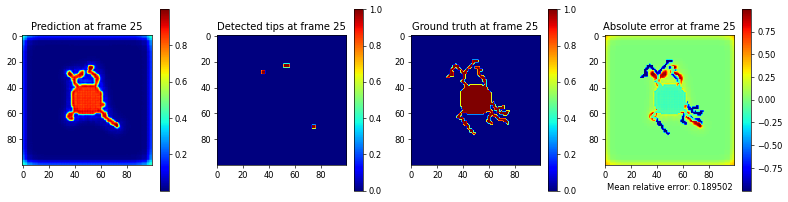

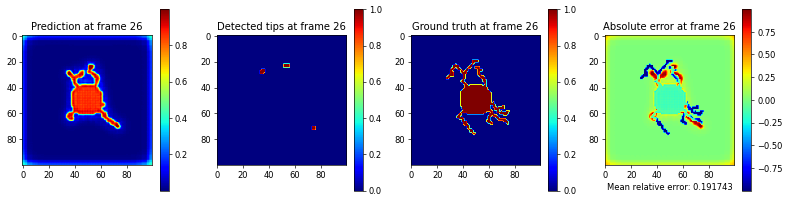

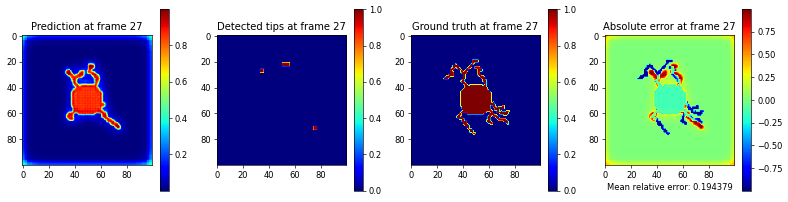

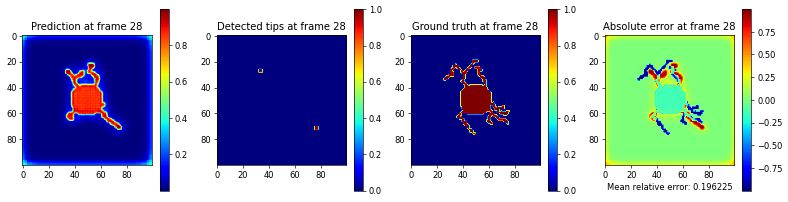

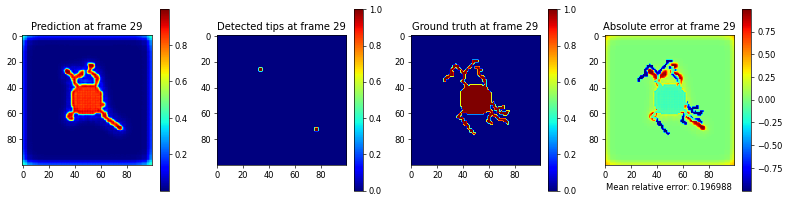

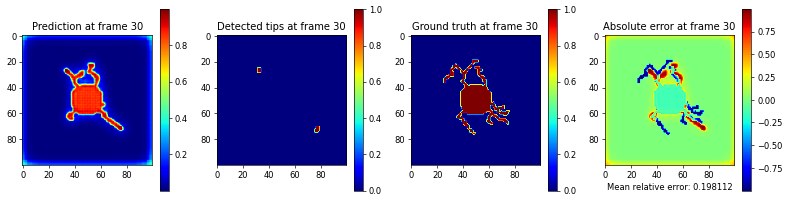

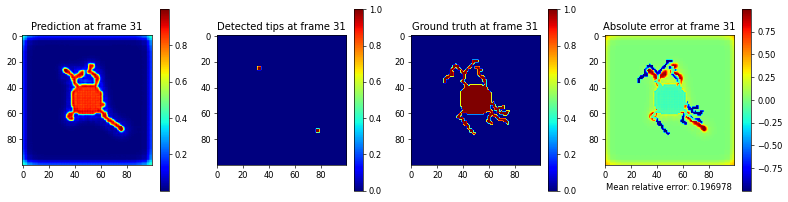

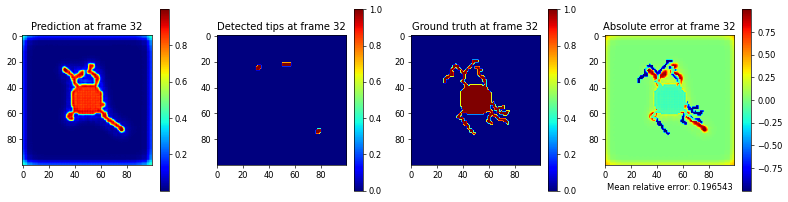

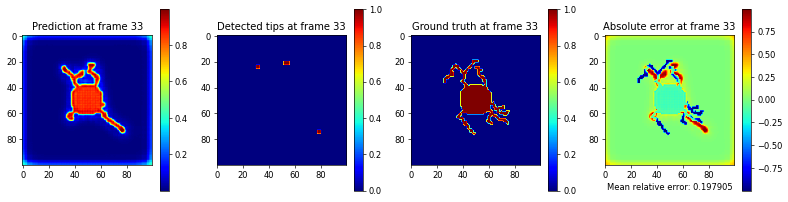

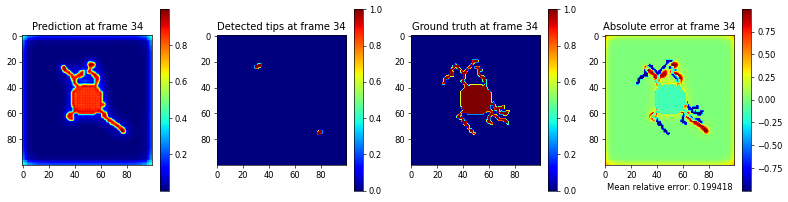

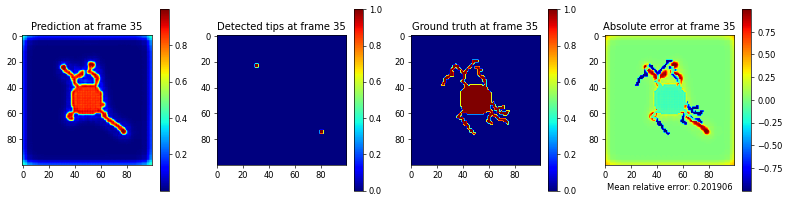

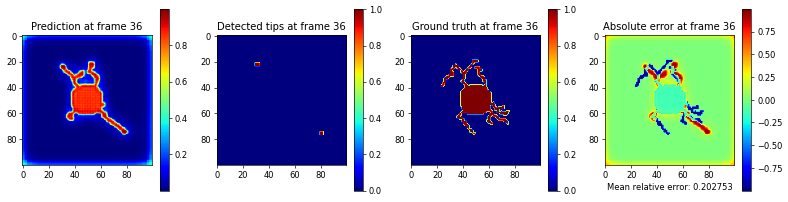

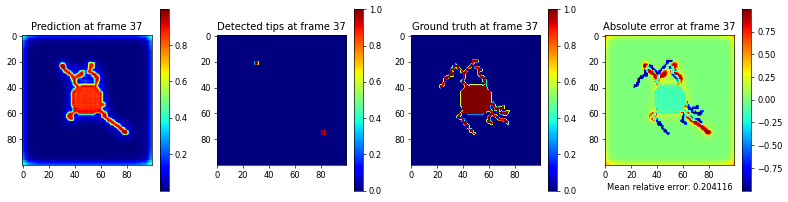

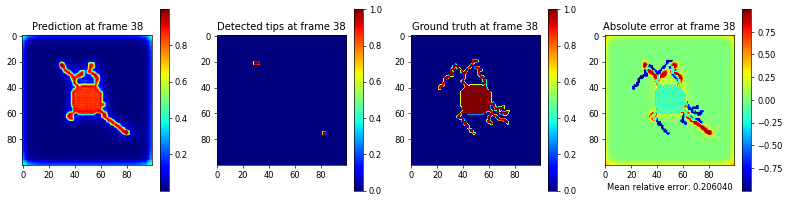

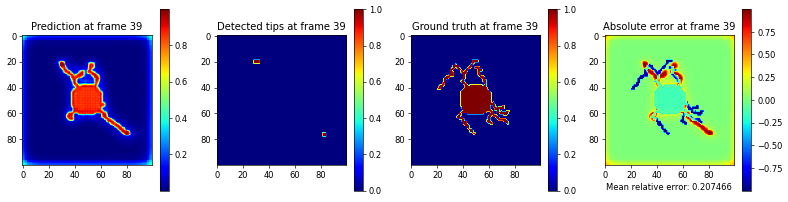

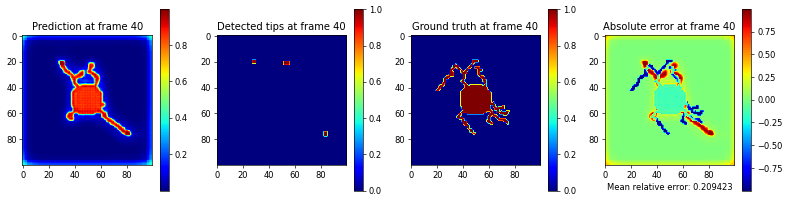

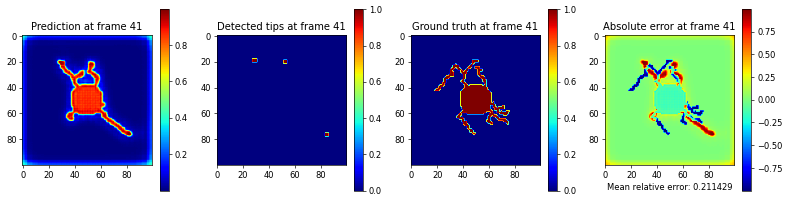

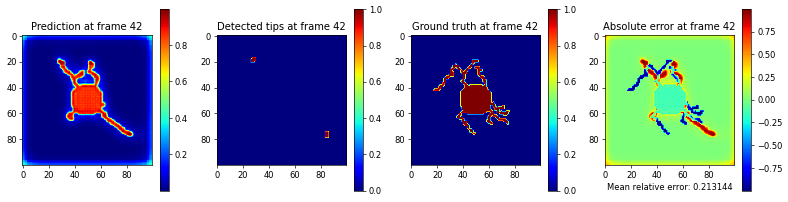

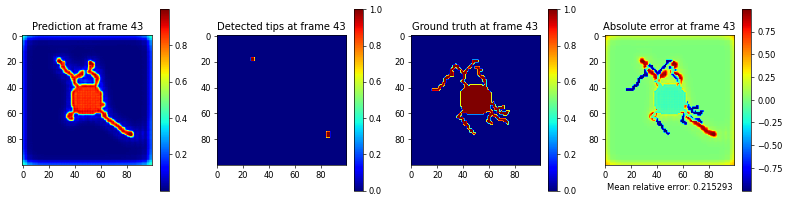

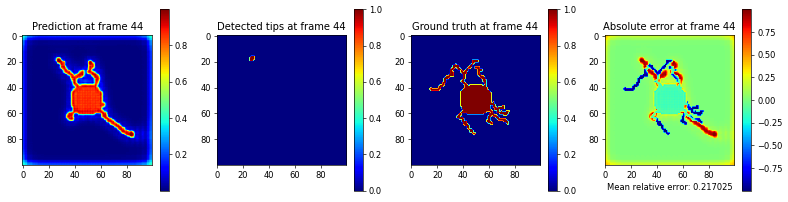

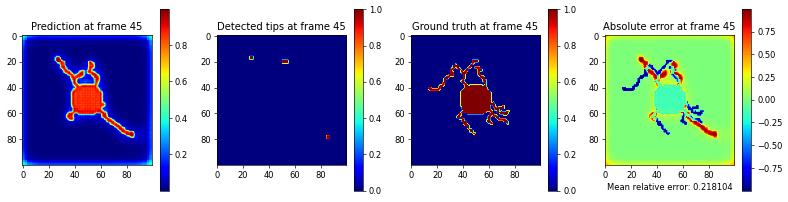

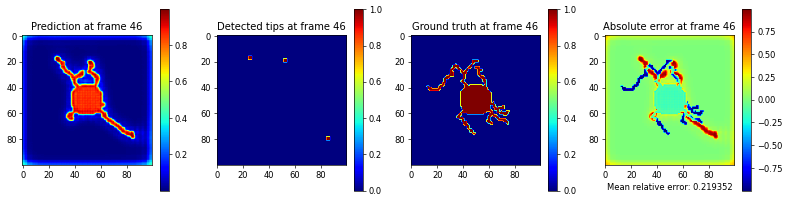

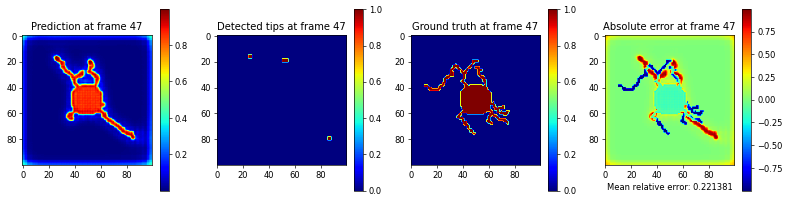

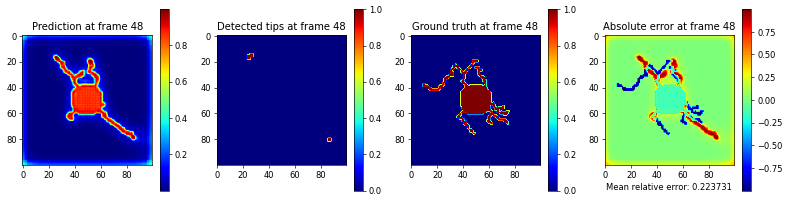

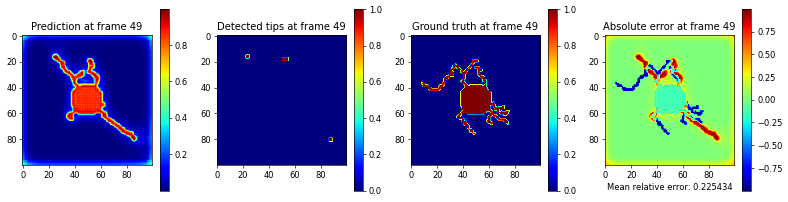

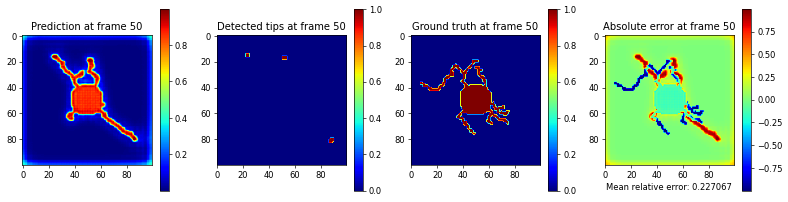

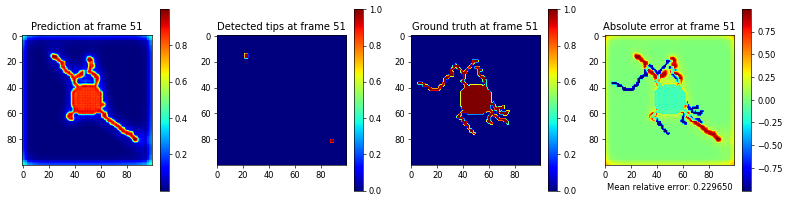

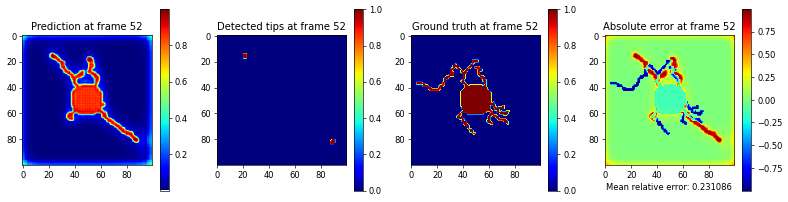

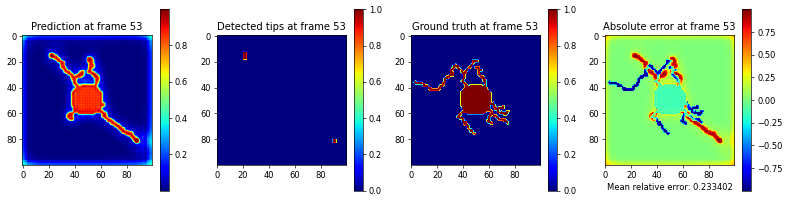

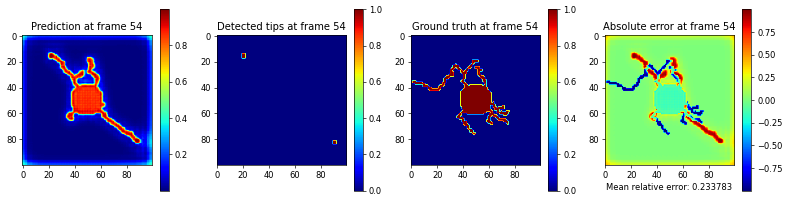

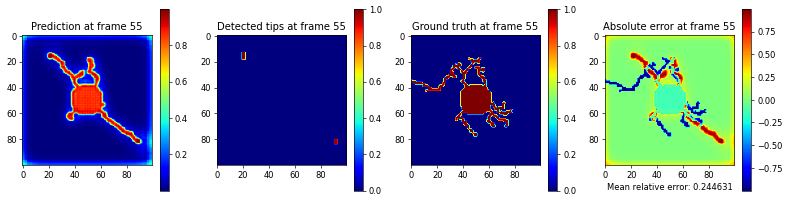

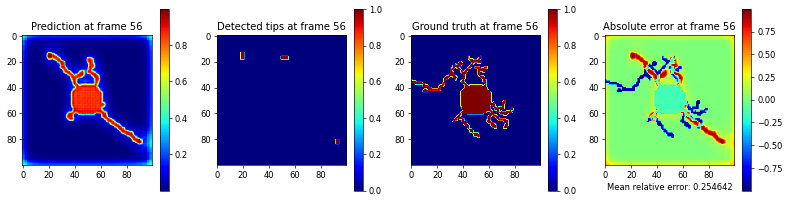

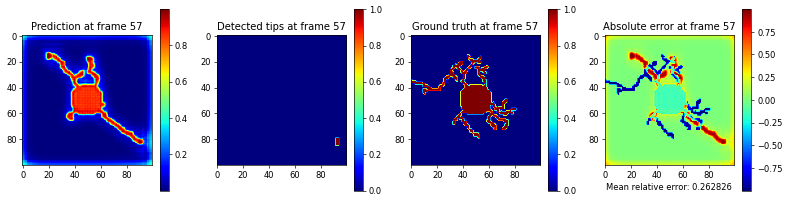

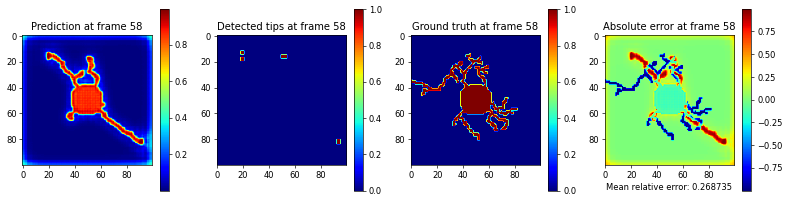

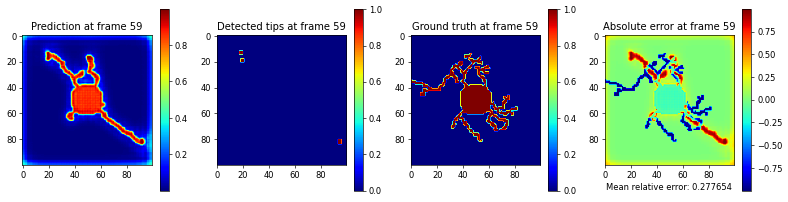

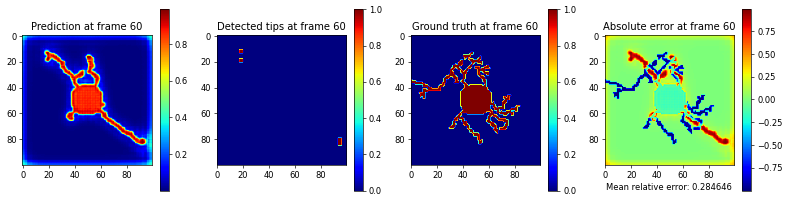

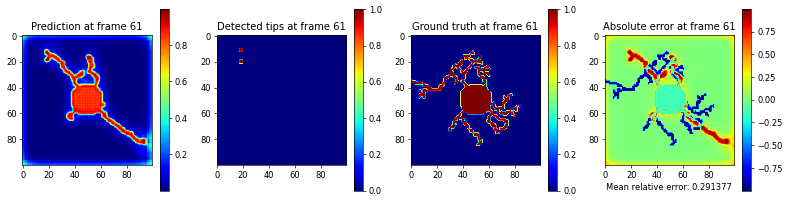

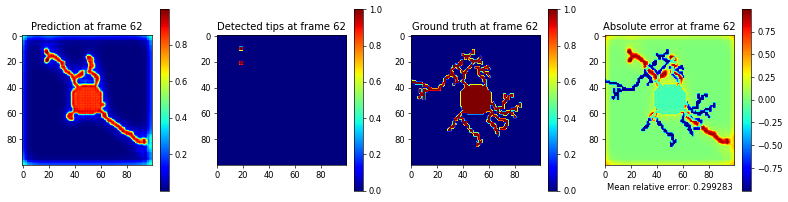

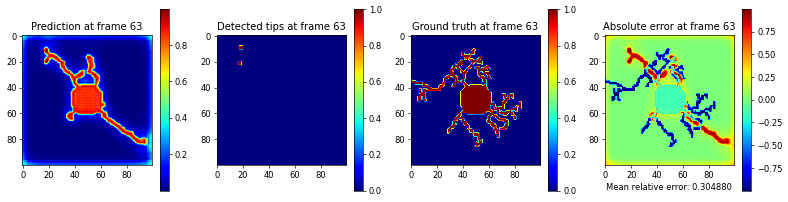

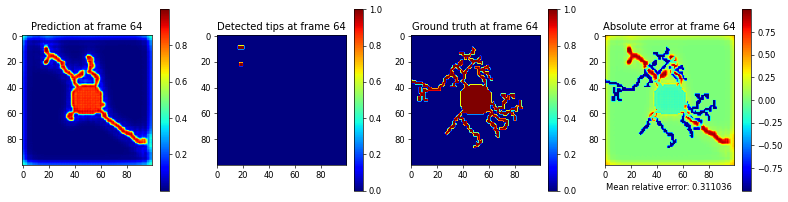

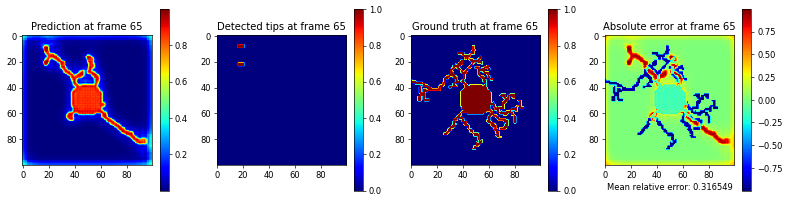

In [55]:
import matlab.engine
eng = matlab.engine.start_matlab()
model = keras.models.load_model('./saved_model/model_conv_lstm', compile=False)
model.compile(loss=mreloss)

rand_case = np.random.randint((len(val_dataset)))

example_x = x_val[rand_case,...]
example_y = y_val[rand_case,...]
example_tips = tips_val[rand_case,...]

plt.figure(figsize=(16, 4), dpi=60)
plt.subplot(1,3,1)
plt.imshow(example_x[0,:,:,0], cmap='jet')
plt.title('Ground truth at frame 0')

plt.subplot(1,3,2)
plt.imshow(example_x[0,:,:,1], cmap='jet')
plt.title('Ground truth at frame 0')

plt.subplot(1,3,3)
plt.imshow(example_x[0,:,:,2], cmap='jet')
plt.title('Ground truth at frame 0')
plt.show()

x_in = np.expand_dims(np.expand_dims(example_x[0,...],axis=0),axis=0)

for i in range(example_x.shape[0]-3):
    # model = keras.models.load_model('./saved_model/model_conv_lstm')
    new_prediction = model.predict(x_in,verbose="0")
    # keras.backend.clear_session()
    temp = np.zeros([1,1,100,100,3])

    tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(new_prediction[0,0,:,:,0]).astype('float64')),5000))
    # model = keras.models.load_model('./saved_model/model_tipsCNN_predBased_mre', compile=False)
    # model.compile(loss=mreloss)
    # tips = push(model.predict(np.expand_dims(np.expand_dims(new_prediction[0,0,:,:,0],axis=0),axis=3),verbose="0"),0.5)
    # keras.backend.clear_session()
    # tips = np.round(example_tips[i,:,:,0])

    temp[0,0,:,:,0] = x_in[0,0,:,:,1]
    temp[0,0,:,:,1] = x_in[0,0,:,:,2]
    # temp[0,0,:,:,2] = np.round(new_prediction[0,0,:,:,0])+tips[0,:,:,0]
    temp[0,0,:,:,2] = np.round(new_prediction[0,0,:,:,0])+tips
    x_in = temp

    mre = np.sqrt(np.sum(np.square(new_prediction[0,0,:,:,0]-example_y[i,:,:,0])/(new_prediction.shape[2]*new_prediction.shape[3])))

    plt.figure(figsize=(16, 4), dpi=60)

    plt.subplot(1,4,1)
    plt.imshow(new_prediction[0,0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Prediction at frame %d'%(i+3))

    plt.subplot(1,4,2)
    plt.imshow(tips, cmap='jet')
    plt.colorbar()
    plt.title('Detected tips at frame %d'%(i+3))

    plt.subplot(1,4,3)
    plt.imshow(example_y[i,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Ground truth at frame %d'%(i+3))

    plt.subplot(1,4,4)
    plt.imshow(new_prediction[0,0,:,:,0]-example_y[i,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Absolute error at frame %d'%(i+3))
    plt.xlabel('Mean relative error: %f'%mre)

    plt.show()

# eng.quit()


In [47]:
import matlab.engine
from tqdm import tqdm
eng = matlab.engine.start_matlab()

mre = []
for rand_case in tqdm (range(len(val_dataset)), desc="Running ..."):
    example_x = x_val[rand_case,...]
    example_y = y_val[rand_case,...]
    x_in = np.expand_dims(np.expand_dims(example_x[0,...],axis=0),axis=0)

    for i in range(example_x.shape[0]-3):

        new_prediction = model.predict(x_in, verbose="0")
        temp = np.zeros([1,1,100,100,3])

        # tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(new_prediction[0,0,:,:,0]).astype('float64')),5000))
        tips = np.round(example_tips[i,:,:,0])
        temp[0,0,:,:,0] = x_in[0,0,:,:,1]
        temp[0,0,:,:,1] = x_in[0,0,:,:,2]
        temp[0,0,:,:,2] = np.round(new_prediction[0,0,:,:,0])+tips

        x_in = temp

        mre.append(np.sqrt(np.sum(np.square(new_prediction[0,0,:,:,0]-example_y[i,:,:,0])/(new_prediction.shape[2]*new_prediction.shape[3]))))

print(sum(mre) / len(mre))
eng.quit()


Running ...: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]

0.18740752740080752
